In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from sklearn.metrics import pairwise_distances

In [20]:
format_plots()
#format_pizza_plots()

In [21]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [22]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            cohort_dist[x,y]=scipy.spatial.distance.jensenshannon(p=np.array(i), q=np.array(j))
            y=y+1
        y=0
        x=x+1
    return cohort_dist

In [23]:
## update data
def remove_crl_male(df):
    max=39
    df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

def remove_crl_female(df):
    max=39
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    #syll=0
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [24]:
# arrange data
# pseudo data males
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet')
m_psd = pd.read_parquet(path)
m_psd=m_psd.reset_index()
m_psd=m_psd[['uuid','pseudotime_rank','age','pseudo_age']]

#make sure only animals in clean v2 are in the male dataframe:
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_v2.parquet')
df_males = pd.read_parquet(path)
df_males = remove_crl_male(df_males)
m_psd = df_males.merge(m_psd, on='uuid', how='left')

#do some cleaning up
m_psd.rename(columns={'pseudotime_rank': 'psd'}, inplace=True)
m_psd.set_index(['psd','uuid','age'], append=True, inplace=True)
m_psd['remapped_bins'] = m_psd['pseudo_age']
m_psd.set_index(['remapped_bins'], 
                append=True, inplace=True)
m_psd = m_psd.filter(regex=r'\d')

In [25]:
# calculate distance for chronological age and pseudo age
# for age
age_data=df_males.copy()
bins=[]
kld_age=[]
u_age=[]
c_age=[]
exp=[]
for age,_df in enumerate(age_data.groupby('age')):
    bins.extend(_df[1].index.get_level_values('age').to_numpy())
    exp.extend(['age']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_age.extend(np.mean(kld_temp, axis=1))
    u_age.extend(np.mean(utemp, axis=1))
    c_age.extend(np.mean(ctemp, axis=1))

In [26]:
# calculate distance for chronological age and pseudo age
# for age
psd_data=m_psd.copy()
kld_psd=[]
u_psd=[]
c_psd=[]
for age,_df in enumerate(psd_data.groupby('remapped_bins')):
    bins.extend(_df[1].index.get_level_values('remapped_bins').to_numpy())
    exp.extend(['psd']*len(_df[1]))
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    utemp = pairwise_distances(data_temp)
    ctemp = pairwise_distances(data_temp, metric = 'cosine')
    kld_psd.extend(np.mean(kld_temp, axis=1))
    u_psd.extend(np.mean(utemp, axis=1))
    c_psd.extend(np.mean(ctemp, axis=1))

In [27]:
df=pd.DataFrame()
df['bins']=bins
df['jsd']=np.append(kld_age,kld_psd)
df['exp']=exp
df['euc']=np.append(u_age,u_psd)
df['cosine']=np.append(c_age,c_psd)

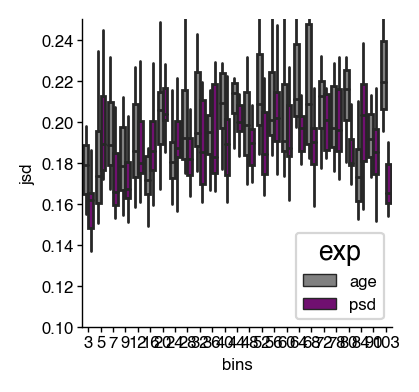

In [28]:
# plot jsd values values
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="jsd", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.1,0.25)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_compare.pdf', bbox_inches='tight')

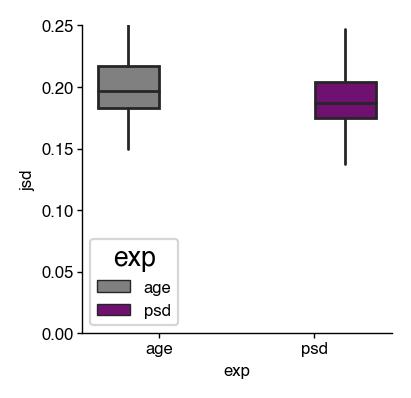

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="jsd", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.0,0.25)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')

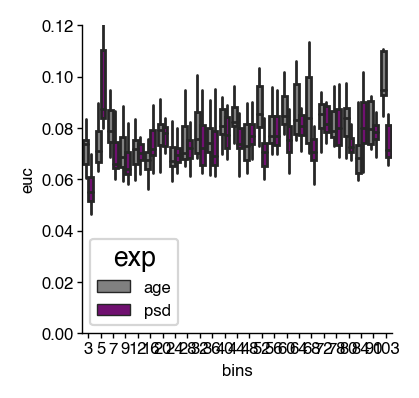

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="bins", y="euc", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
ax.set_ylim(0.0,0.12)
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'I_euc_within_age_compare.pdf', bbox_inches='tight')

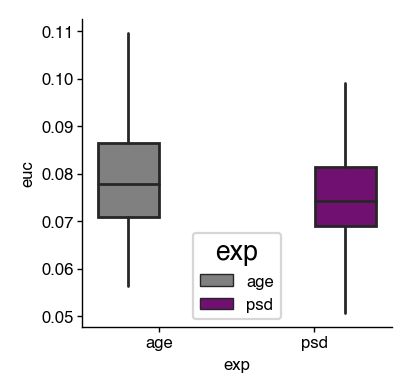

In [31]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="euc", hue='exp', 
             palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.12)
sns.despine()
c = PlotConfig()

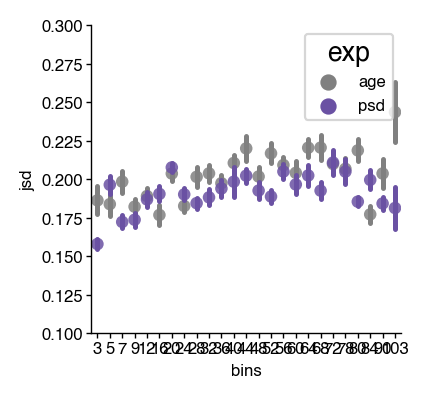

In [45]:
## show mean

fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.pointplot(data=df, x="bins", y="jsd", hue='exp', 
            #notch= True,
            estimator='mean',
            #hue='age',
            errorbar = 'se',
            palette = ['grey','#6a51a3'], 
            #palette = cmm, 
            #dodge=True,
            #alpha=0.5,
            join=False)
ax.set_ylim(0.10,0.30)
plt.setp(ax.collections, alpha=.85)
plt.setp(ax.collections, edgecolor='none')
sns.despine()

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_mean.pdf', bbox_inches='tight')

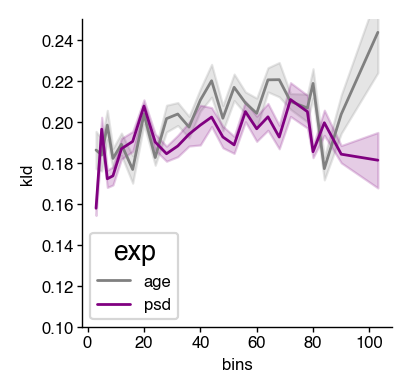

In [17]:
## show means line

fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.lineplot(data=df, x="bins", y="jsd", hue='exp', 
            #notch= True,
            estimator='mean',
            errorbar = 'se',
            palette = ['grey','purple'], 
            #dodge=True,
            #alpha=0.5,
            #join=False,
            )
ax.set_ylim(0.10,0.25)
sns.despine()

c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'I_jsd_within_age_mean.pdf', bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(2,2)
sns.boxplot(data=df, x="exp", y="jsd", hue='exp', 
               notch=True,
               palette = ['grey','purple'], dodge=True, showfliers=False, linewidth=1, showcaps=False,)
#ax.set_ylim(0.0,0.15)
sns.despine()
c = PlotConfig()
#fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'euc_within_age_compare.pdf', bbox_inches='tight')